# 2nd Level Model Structure: Reactive Stage

In [1]:
%store -r dic

In [2]:
import sys
import os
import dill
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt
os.environ['DISPLAY'] = '0'

In [3]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF, augmented_objective, add_solver,\
                                    select_MPCC, which_MPCC, disable_restoration
from utility.data_utility import cal_cnumber

# stage construction rules
from physics.kinetics.kinetics_reactive import kinetic_block_rule
from physics.energy.energy_reactive import energy_block_rule
from physics.VLE.VLE_reactive_MPCC_P import VLE_block_rule
from physics.MPCC.MPCC_P import P_NCP_block_rule, P_Reg_block_rule, P_pf_block_rule

In [4]:
model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [5]:
model.inlet = pe.Set(initialize=['in','R'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

In [6]:
# model.comp_light = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 1 and cal_cnumber(i) <= 4])
# model.comp_naphtha = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 5 and cal_cnumber(i) <= 7])
# model.comp_gasoline = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 8 and cal_cnumber(i) <= 12])
# model.comp_diesel = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 13 and cal_cnumber(i) <= 18])
# model.comp_heavy = pe.Set(initialize = [i for i in m.COMP_ORG if cal_cnumber(i) >= 19 and cal_cnumber(i) <= 56])

# Global Variables

In [7]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=30000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

In [8]:
model.P_V = pe.Var(within=pe.NonNegativeReals)
model.P_naphtha = pe.Var(within=pe.NonNegativeReals)
model.P_gasoline = pe.Var(within=pe.NonNegativeReals)
model.P_diesel = pe.Var(within=pe.NonNegativeReals)
model.P_heavy = pe.Var(within=pe.NonNegativeReals)

# Construct Individual Blocks

In [9]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [10]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [11]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [12]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [13]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [14]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [15]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Product Amount / Total Revenue

In [16]:
def P_V_rule(model):
    return model.P_V == sum(
        (model.V['out'] * model.y[i] + model.L['out'] * model.x[i]) * dic[i,'V']
    for i in m.COMP_TOTAL)
                            
model.P_light_con = pe.Constraint(rule=P_V_rule)

def P_naphtha_rule(model):
    return model.P_naphtha == sum(
        (model.V['out'] * model.y[i] + model.L['out'] * model.x[i]) * dic[i,'naphtha']
    for i in m.COMP_TOTAL)

model.P_naphtha_con = pe.Constraint(rule=P_naphtha_rule)

def P_gasoline_rule(model):
    return model.P_gasoline == sum(
        (model.V['out'] * model.y[i] + model.L['out'] * model.x[i]) * dic[i,'gasoline']
    for i in m.COMP_TOTAL)

model.P_gasoline_con = pe.Constraint(rule=P_gasoline_rule)

def P_diesel_rule(model):
    return model.P_diesel == sum(
        (model.V['out'] * model.y[i] + model.L['out'] * model.x[i]) * dic[i,'diesel']
    for i in m.COMP_TOTAL)

model.P_diesel_con = pe.Constraint(rule=P_diesel_rule)

def P_heavy_rule(model):
    return model.P_heavy == sum(
        (model.V['out'] * model.y[i] + model.L['out'] * model.x[i]) * dic[i,'heavy']
    for i in m.COMP_TOTAL)

model.P_heavy_con = pe.Constraint(rule=P_heavy_rule)

## MPCC: Add all three

In [17]:
model.MPCC_P_pf = pe.Block(rule = P_pf_block_rule)
model.MPCC_P_NCP = pe.Block(rule = P_NCP_block_rule)
model.MPCC_P_Reg = pe.Block(rule = P_Reg_block_rule)

> Importing MPCC_P_pf Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_pf.s_L
| MPCC_P_pf.s_V
| MPCC_P_pf.pf
| MPCC_P_pf.epi
| MPCC_P_pf.rho
--------------------------------------------------
> Spliting pressure used in VLE
Deleted original P_equal constraint

> Deleted kinetics rates constraints
> Added f_V_MPCC, updated rates constraints

> Importing MPCC_P_NCP Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_NCP.s_L
| MPCC_P_NCP.s_V
| MPCC_P_NCP.epi
--------------------------------------------------
> Adding complementarity constraint, spliting pressure used in VLE
> No constraint to delete

> Already replaced f_V_MPCC

> Importing MPCC_P_Reg Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC_P_Reg.s_L
| MPCC_P_Reg.s_V
| MPCC_P_Reg.epi
--------------------------------------------------
> Adding comple

In [18]:
select_MPCC(model,'pf')

> Selected MPCC: MPCC_P_pf
s_L:  0
s_V:  0



# Testing

In [19]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [20]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['R'].fix(0)
model.L['P'].fix(0)

model.V['in'].fix(0)
model.V['R'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [21]:
model.cat.fix(30000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(8.88)
model.z['CO'].fix(1/(1+2)-0/2)
model.z['H2'].fix(2/(1+2)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [22]:
# model.F.setlb(1e-3)
# model.F.setub(10)
model.T.setub(300+273.15)

# Objective

In [23]:
opt = add_solver(pe, max_iter = 50000, warm_start = False, output = False)
disable_restoration(mode = 'enable')

In [24]:
check_DOF(pe,model)

Active Equality Constraints:	 1191
Active Inequality Constraints:	 1
Active Variables:		 1529
Fixed Variables:		 334
DOF:				 4


In [25]:
model.T.setub(220+273.15)

In [26]:
model.obj = augmented_objective(pe,model,model.T, sense=pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> T - MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [27]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=50000

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = ma97                  yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse           yes
                                  ma97_u = 1e-06                 yes
                 

  60 -4.2284788e+02 4.03e+03 2.23e+06  -1.0 1.30e+04    -  8.73e-05 3.49e-02h  1
  61 -4.2281820e+02 4.03e+03 2.23e+06  -1.0 1.72e+04    -  2.29e-01 4.86e-04h  1
  62 -4.2284848e+02 4.02e+03 2.23e+06  -1.0 2.50e+03    -  2.47e-01 6.28e-04h  1
  63 -4.3345495e+02 1.32e+03 8.39e+06  -1.0 2.38e+03    -  3.52e-02 2.17e-01h  1
  64 -4.3481911e+02 1.45e+03 6.92e+06  -1.0 2.20e+03    -  3.81e-02 3.87e-02h  1
  65 -4.3482737e+02 1.45e+03 6.92e+06  -1.0 2.18e+03    -  5.38e-01 2.48e-04h  2
  66 -4.3483148e+02 1.45e+03 1.34e+07  -1.0 2.18e+03    -  9.75e-02 1.25e-04h  2
  67 -4.3482725e+02 1.45e+03 1.25e+07  -1.0 2.13e+03    -  5.46e-05 6.34e-05h  2
  68 -4.3482247e+02 1.45e+03 6.86e+06  -1.0 1.92e+04    -  3.17e-07 1.05e-04f  1
  69 -4.4372371e+02 1.38e+03 2.43e+07  -1.0 5.23e+04    -  4.10e-05 1.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.4381789e+02 1.38e+03 2.43e+07  -1.0 3.47e+04    -  2.69e-02 3.11e-04h  1
  71r-4.4381789e+02 1.38e+03

 158r-4.0215842e+02 2.95e+01 1.19e+03   0.9 4.76e+00    -  3.86e-01 4.86e-01H  1
 159r-4.0074230e+02 6.75e+02 2.16e+04   0.9 2.60e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r-4.0185601e+02 3.58e+01 1.89e+03   0.9 7.16e+00    -  9.57e-01 9.12e-01h  1
 161r-4.0086349e+02 1.55e+01 2.26e+03   0.9 4.20e+00    -  1.00e+00 1.00e+00f  1
 162r-4.0105640e+02 1.12e-01 2.56e+00   0.9 1.38e+00    -  1.00e+00 1.00e+00h  1
 163 -4.0112051e+02 1.11e-01 4.88e+02  -1.0 1.09e+03    -  1.48e-02 8.32e-04h  3
 164 -4.0117938e+02 1.11e-01 1.44e+03  -1.0 1.79e+03    -  8.02e-03 1.28e-03h  2
 165 -4.0092513e+02 1.11e-01 2.55e+04  -1.0 3.27e+03    -  2.32e-02 1.40e-03h  1
 166r-4.0092513e+02 1.11e-01 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.26e-07R 10
 167r-4.0092839e+02 3.20e+00 9.96e+02  -1.0 2.50e+03    -  1.23e-02 2.85e-03f  1
 168r-4.0093617e+02 6.07e+00 9.89e+02  -1.0 1.71e+03    -  6.69e-03 7.70e-03f  1
 169r-4.0094663e+02 4.24e+01

In [28]:
opt = add_solver(pe, max_iter = 5000, warm_start = True, output = False)
disable_restoration(mode = 'disable')

In [29]:
model.T.setub(240+273.15)
model.del_component(model.obj)
model.obj = augmented_objective(pe, model, expr = 43*model.P_naphtha + 90*model.P_gasoline + \
                                128*model.P_diesel + 100*model.P_heavy + 1.3*model.P_V - 2.24*model.F, sense=pe.maximize)
# model.obj = augmented_objective(pe, model, expr = 54*model.P_naphtha + 112*model.P_gasoline + \
#                                 161*model.P_diesel + 350*model.P_heavy + 1.3*model.P_light - 2.24*model.F, sense=pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> 43*P_naphtha + 90*P_gasoline + 128*P_diesel + 100*P_heavy + 1.3*P_V - 2.24*F - MPCC_P_pf.pf
------------------------------------------------------------------------------------------------------------


In [30]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=5000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = ma97                  yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse 

In [31]:
43*model.P_naphtha.value + 90*model.P_gasoline.value + 128*model.P_diesel.value + 100*model.P_heavy.value + 1.3*model.P_V.value - 2.24*model.F.value
# 54*model.P_naphtha.value + 112*model.P_gasoline.value + 161*model.P_diesel.value + 350*model.P_heavy.value + 1.3*model.P_light.value - 2.24*model.F.value

2.2816928074960536

In [32]:
model.T.value, model.VLE_block.P_VLE.value, model.kinetics_block.r_FT_total.value

(503.9377176628252, 20.000000441972922, 2.526563319461933)

In [33]:
model.P_V.value, model.P_naphtha.value, model.P_gasoline.value, model.P_diesel.value, model.P_heavy.value

(1.9006859625437638,
 0.06328541541334701,
 0.11221177926437087,
 0.038284306756677856,
 0.01981276794767101)

In [34]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0322			Vapor: 4.0123			log K
------------------------------------------------------------------------------------------------------------
H2         		 1.0169%			26.3284%			1.4131
CO         		 0.0451%			 0.9175%			1.3083
CO2        		 1.0843%			 9.8761%			0.9594
H2O        		12.1001%			52.9885%			0.6414
C2H4       		 0.1314%			 0.9601%			0.8636
C3H6       		 0.2763%			 0.9815%			0.5505
C4H8       		 0.2314%			 0.7760%			0.5255
C5H10      		 0.3135%			 0.5336%			0.2309
C6H12      		 0.4671%			 0.4423%			-0.0237
C7H14      		 0.6550%			 0.3659%			-0.2529
C8H16      		 0.8797%			 0.3018%			-0.4646
C9H18      		 1.1423%			 0.2478%			-0.6636
C10H20     		 1.4417%			 0.2023%			-0.8529
C11H22     		 1.1298%			 0.1043%			-1.0347
C12H24     		 1.3547%			 0.0835%			-1.2103
C13H26     		 1.5820%			 0.0658%			-1.3809
C14H28     		 1.7959%			 0.0509%			-1.5474
C15H30     		 1.9765%			 0.0385%			-1.7104
C16H32     		 2.1040%			 0.0284%			-1.8705
C17H34     		 2.1632%			 0.0203%

In [35]:
# Conversion
(model.F.value - model.V['out'].value * (model.y['H2'].value + model.y['CO'].value) - \
model.L['out'].value * (model.x['H2'].value + model.x['CO'].value))/model.F.value

0.8768544893827409

In [36]:
import numpy as np
F_range = np.linspace(15,1e-4,40)
Obj_list = []

for f in F_range:
    model.F.fix(f)
    
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    
    Obj_list.append(model.obj())
    
    print('Solved, Feed = {:.2f}\tObj = {:.2f}'.format(f,model.obj()))

Solved, Feed = 15.00	Obj = 2.78
Solved, Feed = 14.62	Obj = 2.77
Solved, Feed = 14.23	Obj = 2.76
Solved, Feed = 13.85	Obj = 2.75
Solved, Feed = 13.46	Obj = 2.73
Solved, Feed = 13.08	Obj = 2.71
Solved, Feed = 12.69	Obj = 2.69
Solved, Feed = 12.31	Obj = 2.66
Solved, Feed = 11.92	Obj = 2.63
Solved, Feed = 11.54	Obj = 2.60
Solved, Feed = 11.15	Obj = 2.56
Solved, Feed = 10.77	Obj = 2.52
Solved, Feed = 10.38	Obj = 2.48
Solved, Feed = 10.00	Obj = 2.43
Solved, Feed = 9.62	Obj = 2.38
Solved, Feed = 9.23	Obj = 2.33
Solved, Feed = 8.85	Obj = 2.28
Solved, Feed = 8.46	Obj = 2.22
Solved, Feed = 8.08	Obj = 2.16
Solved, Feed = 7.69	Obj = 2.09
Solved, Feed = 7.31	Obj = 2.02
Solved, Feed = 6.92	Obj = 1.95
Solved, Feed = 6.54	Obj = 1.87
Solved, Feed = 6.15	Obj = 1.79
Solved, Feed = 5.77	Obj = 1.71
Solved, Feed = 5.38	Obj = 1.62
Solved, Feed = 5.00	Obj = 1.53
Solved, Feed = 4.62	Obj = 1.44
Solved, Feed = 4.23	Obj = 1.34
Solved, Feed = 3.85	Obj = 1.24
Solved, Feed = 3.46	Obj = 1.13
Solved, Feed = 3.08	Obj =

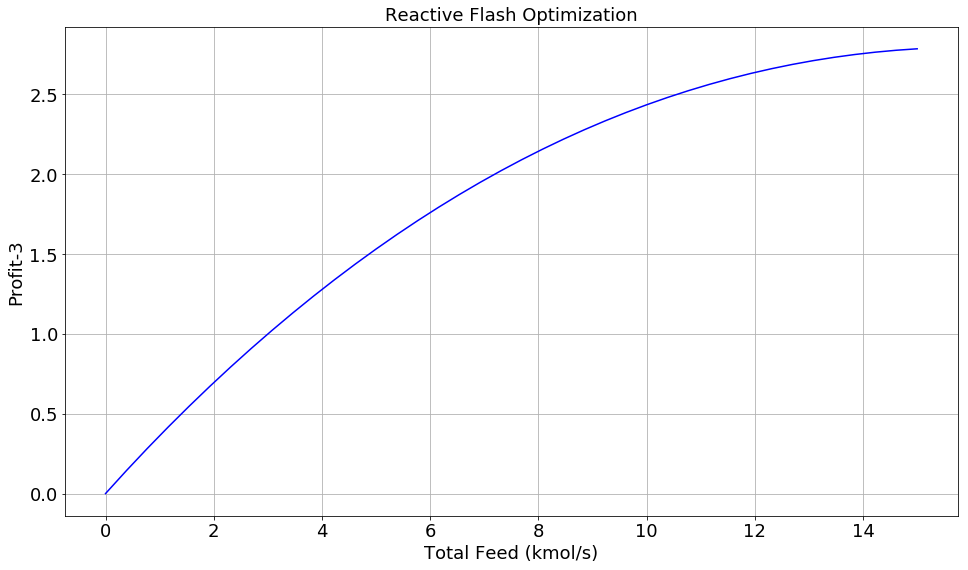

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
line = ax.plot(F_range,Obj_list, 'b-')
ax.set_xlabel('Total Feed (kmol/s)',fontsize=18)
ax.set_ylabel('Profit-3',fontsize=18)
ax.tick_params('y',labelsize=18)
ax.tick_params('x',labelsize=18)
ax.set_title('Reactive Flash Optimization',fontsize=18)
ax.grid()

plt.show()

In [48]:
model.F.fix(8.88)

In [49]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
tol=1e-08
option_file_name=./ipopt.opt
max_iter=5000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06

Using option file "./ipopt.opt".


List of user-set options:

                                    Name   Value                used
                           compl_inf_tol = 1                     yes
                         constr_viol_tol = 1                     yes
                            dual_inf_tol = 1000                  yes
                           linear_solver = ma97                  yes
                              ma86_small = 1e-30                  no
                                  ma86_u = 0.0001                 no
                              ma97_order = best                  yes
                              ma97_small = 1e-30                 yes
                            ma97_switch1 = at_start              yes
                            ma97_switch2 = od_hd_reuse 

In [50]:
43*model.P_naphtha.value + 90*model.P_gasoline.value + 128*model.P_diesel.value + 100*model.P_heavy.value + 1.3*model.P_V.value - 2.24*model.F.value
# 54*model.P_naphtha.value + 112*model.P_gasoline.value + 161*model.P_diesel.value + 350*model.P_heavy.value + 1.3*model.P_light.value - 2.24*model.F.value

2.28169280749605

In [60]:
model.T.value - 273.15, model.VLE_block.P_VLE.value, model.kinetics_block.r_FT_total.value

(230.78771766282512, 20.000000441972922, 2.5265633194619324)

In [52]:
model.P_V.value, model.P_naphtha.value, model.P_gasoline.value, model.P_diesel.value, model.P_heavy.value

(1.900685962543766,
 0.06328541541334703,
 0.11221177926437088,
 0.038284306756677836,
 0.019812767947670996)

In [ ]:
model.P_V.value

In [61]:
model.kinetics_block.r_FT_total.value / (model.F.value / 3)

0.8535686890074095

In [57]:
model.f_V['CO'].value

0.18350275142083564

In [58]:
model.f_V['H2O'].value

10.597699337762739

In [59]:
model.f_V['H2'].value

5.265681158718329

In [55]:
model.kinetics_block.r_FT_total.value

2.5265633194619324

In [46]:
# model.solutions.store_to(results)
# with open('../../saved_solutions/reactive_flash_MPCC_P_200C.pickle','wb') as f:
#     pickle.dump(results,f)

In [47]:
# with open('test_model.pickle','wb') as f:
#     dill.dump(model,f)